# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Boston Housing data set.

## Objectives

You will be able to:
- Understand what interactions are
- Understand how to accommodate for interactions in regression

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Import the Boston data set using `load_boston()`. We won't bother to preprocess the data in this lab. If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
regression = LinearRegression()
boston = load_boston()

Create a baseline model which includes all the variables in the Boston housing data set to predict the house prices. The use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [10]:
boston

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [17]:
## code here
y = pd.DataFrame(boston.target, columns = ['target'])
x = pd.DataFrame(boston.data, columns = boston.feature_names)
data = pd.concat([x, y], axis = 1)

crossv = KFold(n_splits = 10, shuffle = True, random_state = 1)
baseline = np.mean(cross_val_score(regression, x, y, scoring = 'r2', cv = crossv))

In [18]:
baseline

0.7189415144723069

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the R^2. We'll look at the 3 interactions which have the biggest effect on our R^2, so print out the top 3 combinations.

You will create a for loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

In [42]:
from itertools import combinations
combinations = list(combinations(boston.feature_names, 2))
effects = []
for comb in combinations:
    X = x.copy()
    X['interaction_val'] = X[comb[0]] * X[comb[1]]
    value = np.mean(cross_val_score(regression, X, y, scoring = 'r2', cv = crossv))
    effect = value - baseline
    effects.append([comb[0], comb[1], effect])

In [47]:
## code to find top 3 interactions by R^2 value here
effects = sorted(effects, key = lambda iterable: iterable[2], reverse = True)
effects[0:3]

[['RM', 'LSTAT', 0.06753519668939667],
 ['RM', 'TAX', 0.056096980552145514],
 ['RM', 'RAD', 0.049249679207558406]]

## Look at the top 3 interactions: "RM" as a confounding factor

The top three interactions seem to involve "RM", the number of rooms as a confounding variable for all of them. Let's have a look at interaction plots for all three of them. This exercise will involve:

- splitting our data up in 3 groups: one for houses with a few rooms, one for houses with a "medium" amount of rooms, one for a high amount of rooms.
- Create a function `build_interaction_rm`. This function takes an argument `varname` (which can be set equal to the column name as a string) and a column `description` (which describes the variable or varname, to be included on the x-axis of the plot). The function outputs a plot that uses "RM" as a confounding factor. 

We split the data set for high, medium and low amount of rooms for you.

In [52]:
df = x.copy()
all_data = data.copy()

In [53]:
rm = np.asarray(df[["RM"]]).reshape(len(df[["RM"]]))

In [54]:
high_rm = all_data[rm > np.percentile(rm, 67)]
med_rm = all_data[(rm > np.percentile(rm, 33)) & (rm <= np.percentile(rm, 67))]
low_rm = all_data[rm <= np.percentile(rm, 33)]

Create `build_interaction_rm`.

In [65]:
def build_interaction_rm(varname, description): #description is the xlabel of the plot
    x_low = low_rm[varname].values.reshape(-1, 1)
    x_med = med_rm[varname].values.reshape(-1, 1)
    x_high = high_rm[varname].values.reshape(-1, 1)
    
    y_low = low_rm['target']
    y_med = med_rm['target']
    y_high = high_rm['target']
    
    regression_low = LinearRegression()
    regression_med = LinearRegression()
    regression_high = LinearRegression()
    
    regression_low.fit(x_low, y_low)
    regression_med.fit(x_med, y_med)
    regression_high.fit(x_high, y_high)
    
    pred_low = regression_low.predict(x_low)
    pred_med = regression_med.predict(x_med)
    pred_high = regression_high.predict(x_high)
    
    print(regression_low.coef_)
    print(regression_med.coef_)
    print(regression_high.coef_)
    
    plt.figure(figsize = (15,9))
    plt.scatter(x_low, y_low, color = 'blue', alpha = .2, label = 'low rooms')
    plt.scatter(x_med, y_med, color = 'green', alpha = .2, label = 'med rooms')
    plt.scatter(x_high, y_high, color = 'red', alpha = .2, label = 'high rooms')
    
    plt.plot(x_low, pred_low, color = 'blue')
    plt.plot(x_med, pred_med, color = 'green')
    plt.plot(x_high, pred_high, color = 'red')
    
    plt.xlabel(description)
    plt.ylabel('house value')
    plt.legend()
    plt.show()
    return

Next, use build_interaction_rm with the three variables that came out with the highest effect on $R^2$

[-0.51981339]
[-0.67588205]
[-1.46614438]


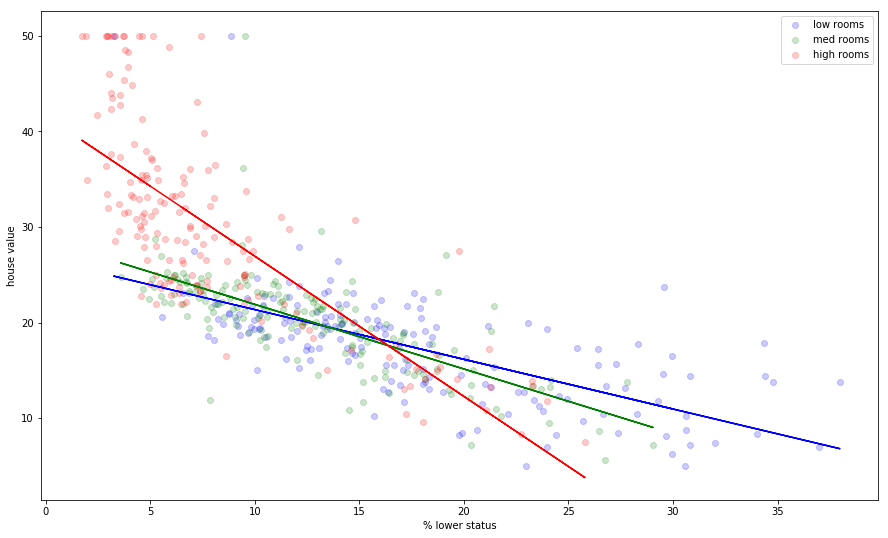

In [66]:
# first plot
effects[0][1] #'LSTAT'
build_interaction_rm(effects[0][1], '% lower status')

[-0.01166035]
[-0.01431143]
[-0.03708037]


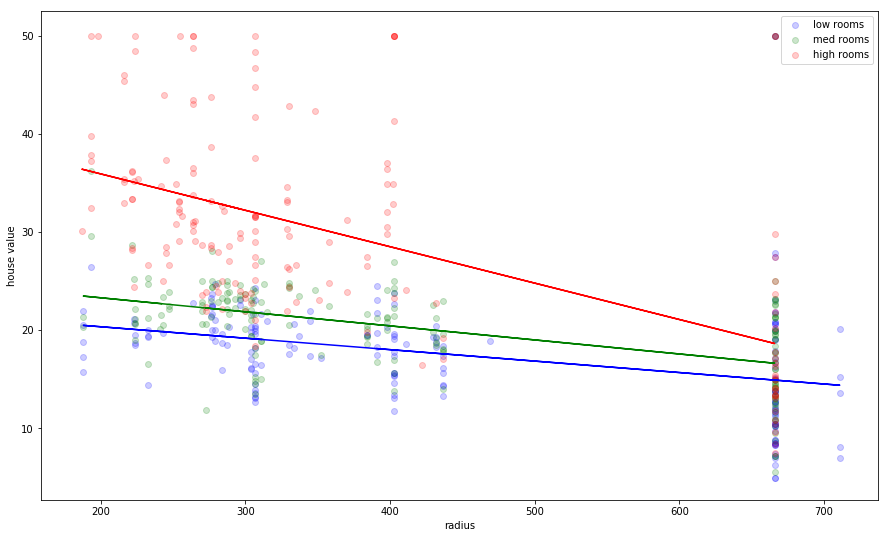

In [70]:
# second plot
effects[1][1] #'RAD'
build_interaction_rm(effects[1][1], 'radius')

[-0.17393132]
[-0.24276834]
[-0.66803793]


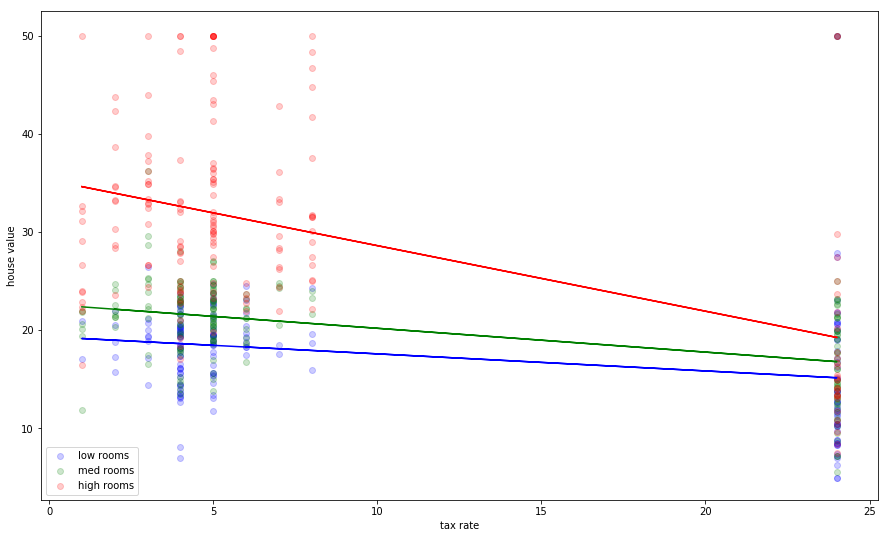

In [71]:
# third plot
effects[2][1] #'TAX'
build_interaction_rm(effects[2][1], 'tax rate')

## Build a final model including all three interactions at once

Use 10-fold crossvalidation.

In [105]:
# code here
regression = LinearRegression()
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)
data_with_interactions = data.copy()
top_3 = effects[0:3]
for effect in top_3:
    print(effect)
    column = effect[0] + '_' + effect[1]
    data_with_interactions[column] = data[effect[0]] * data[effect[1]]

final = np.mean(cross_val_score(regression, data_with_interactions, y, scoring="r2", cv= crossvalidation))

['RM', 'LSTAT', 0.06753519668939667]
['RM', 'TAX', 0.056096980552145514]
['RM', 'RAD', 0.049249679207558406]


In [104]:
# code here
final

1.0

Our $R^2$ has increased considerably! Let's have a look in statsmodels to see if all these interactions are significant.

In [102]:
# code here
import statsmodels.api as sm
df_inter_sm = sm.add_constant(data_with_interactions)
model = sm.OLS(y,df_inter_sm)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.203e+28
Date:                Sun, 07 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:40:42   Log-Likelihood:                 14121.
No. Observations:                 506   AIC:                        -2.821e+04
Df Residuals:                     488   BIC:                        -2.813e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.487e-14   3.46e-13      0.072      0.943   -6.55e-13    7.05e-13
CRIM       -6.163e-16   1.35e-15     -0.456      0.648   -3.27e-15    2.04e-15
ZN          -1.11e-16   5.53e-16     -0.201      0.841    -1.2e-15    9.76e-16
INDUS       2.914e-16   2.45e-15      0.119      0.906   -4.53e-15    5.11e-15
CHAS       -3.553e-15   3.48e-14     -0.102      0.919   -7.19e-14    6.48e-14
NOX        -1.055e-14   1.55e-13     -0.068      0.946   -3.15e-13    2.93e-13
RM         -1.776e-15   5.11e-14     -0.035      0.972   -1.02e-13    9.86e-14
AGE        -1.318e-16   5.28e-16     -0.250      0.803   -1.17e-15    9.06e-16
DIS        -1.998e-15   8.35e-15     -0.239      0.811   -1.84e-14    1.44e-14
RAD         2.442e-15   2.22e-14      0.110      0.912   -4.11e-14     4.6e-14
TAX        -2.776e-16   1.14e-15     -0.243      0.808   -2.52e-15    1.97e-15
PTRATIO     -4.58e-16   5.43e-15     -0.084      0.933   -1.11e-14    1.02e-14
B           6.896e-16   1.08e-16      6.382      0.000    4.77e-16    9.02e-16
LSTAT       1.249e-15    1.1e-14      0.113      0.910   -2.04e-14    2.29e-14
target         1.0000    2.1e-15   4.76e+14      0.000       1.000       1.000
RM_LSTAT    4.163e-17   1.99e-15      0.021      0.983   -3.86e-15    3.94e-15
RM_TAX     -7.806e-17   1.85e-16     -0.423      0.672   -4.41e-16    2.84e-16
RM_RAD     -5.274e-16   3.62e-15     -0.145      0.884   -7.65e-15    6.59e-15
==============================================================================
Omnibus:                       80.701   Durbin-Watson:                   0.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.868
Skew:                           1.153   Prob(JB):                     4.19e-26
Kurtosis:                       3.472   Cond. No.                     1.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What is your conclusion here?

In [ ]:
# formulate your conclusion
#Big difference in r2, probably some sort of error in the code because r2 should not be 1. Point taken overall though

## Summary

You now understand how to include interaction effects in your model!